# Comparisson between different pre trained models on ImageNet

## Environment

### Whether Pillow or Pillow-SIMD is using libjpeg-turbo?

In [19]:
from PIL import features, Image
from packaging import version

if version.parse(Image.PILLOW_VERSION) >= version.parse("5.4.0"):
    if features.check_feature('libjpeg_turbo'):
        print("libjpeg-turbo is on")
    else:
        print("libjpeg-turbo is not on")
else:
    print("libjpeg-turbo' status can't be derived - need Pillow(-SIMD)? >= 5.4.0 to tell, current version {}".format(Image.PILLOW_VERSION))

libjpeg-turbo is not on


### Confirm TensorFlow can see the GPU

In [20]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


### System Information

In [ ]:
import tensorflow as tf
import platform
from tensorflow.python.client import device_lib
import tensorflow.keras

!python3 --version

print('\nTensorFlow Version: ', tf.__version__)

print('\nNVIDIA:')
!nvcc --version
!nvidia-smi
!nvidia-smi topo -m

print('\nCPU:')
!lscpu

print('\nMemory:')
!cat /proc/meminfo

print('\nOS:')
print(platform.platform())

print('\nDevices:')
print(device_lib.list_local_devices())

## Common Parameters

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from visuals import *
from data import *
from collections import Counter

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_folder = '../data/isic2019'

model_folder = 'models'
history_folder = 'history'
pred_result_folder_val = 'val_predict_results'
out_dist_pred_result_folder = 'out_dist_predict_results'
    
workers = os.cpu_count()

# How to handle SVG fonts
plt.rcParams['svg.fonttype'] = 'none'

## Import Training Data

Number of known categories: 8
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'] 

Number of unknown categories: 1
UNK 

Category to Index:
{'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7, 'UNK': 8} 

Training data has 25331 samples.
'MEL':	4522	(17.85%)
'NV':	12875	(50.83%)
'BCC':	3323	(13.12%)
'AK':	867	(3.42%)
'BKL':	2624	(10.36%)
'DF':	239	(0.94%)
'VASC':	253	(1.00%)
'SCC':	628	(2.48%)
'UNK':	0	(0.00%)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,path,category
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,1
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,1
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,1
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/ISIC_2019_Training_Input/ISIC...,0


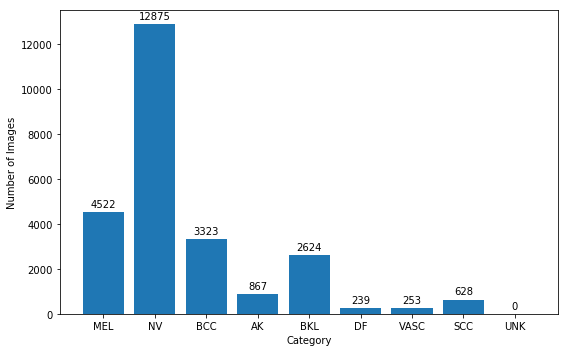

In [31]:
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Training_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Training_GroundTruth.csv')

df_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(training_image_folder, ground_truth_file)
known_category_num = len(known_category_names)
print("Number of known categories: {}".format(known_category_num))
print(known_category_names, '\n')
unknown_category_num = 1
print("Number of unknown categories: {}".format(unknown_category_num))
print(unknown_category_name, '\n')
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

# mapping from category to index
print('Category to Index:')
category_to_index = dict((c, i) for i, c in enumerate(all_category_names))
print(category_to_index, '\n')

count_per_category = Counter(df_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Training data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
# plt.bar(count_per_category.keys(), count_per_category.values())
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()

df_ground_truth.head()

### Shuffle and Split Training Data into Training  and Validation Sets

In [22]:
df_train, df_val = train_validation_split(df_ground_truth)

# Training Set
sample_count_train = df_train.shape[0]
print("Training set has {} samples.".format(sample_count_train))
count_per_category_train = Counter(df_train['category'])
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category_train[i], count_per_category_train[i]*100/sample_count_train))

# Validation Set
sample_count_val = df_val.shape[0]
print("\nValidation set has {} samples.".format(sample_count_val))

Training set has 20264 samples.
'MEL':	3618	(17.85%)
'NV':	10300	(50.83%)
'BCC':	2658	(13.12%)
'AK':	694	(3.42%)
'BKL':	2099	(10.36%)
'DF':	191	(0.94%)
'VASC':	202	(1.00%)
'SCC':	502	(2.48%)
'UNK':	0	(0.00%)

Validation set has 5067 samples.


### Class Weights based on the Traning Set

Class Weights (without UNK):
'MEL':	0.700111
'NV':	0.245922
'BCC':	0.952972
'AK':	3.649856
'BKL':	1.206765
'DF':	13.261780
'VASC':	12.539604
'SCC':	5.045817


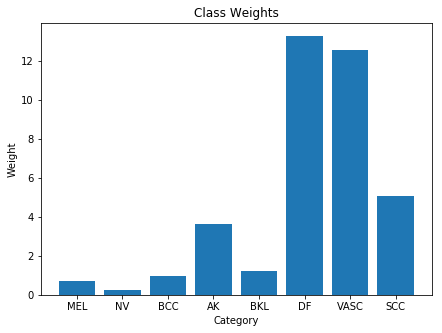

In [35]:
class_weight_dict, class_weights = compute_class_weight_dict(df_train)
print('Class Weights (without UNK):')
for i, c in enumerate(known_category_names):
    print("'%s':\t%f" % (c, class_weight_dict[i]))

# Create a bar chart
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
ax.set_title('Class Weights')
ax.set(xlabel='Category', ylabel='Weight')
plt.bar(known_category_names, [class_weight_dict[i] for i in range(known_category_num)]);

## Transfer Learning

### Train Models by Transfer Learning

In [ ]:
!python3 main.py ../data/isic2019 --training --epoch 100 --batchsize 32 --maxqueuesize 10 --model DenseNet201 EfficientNetB0 EfficientNetB1 EfficientNetB2 EfficientNetB3 EfficientNetB4 VGG16 VGG19 ResNet50

### Complexity Graph of Transfer Learning Models

../history/DenseNet201/DenseNet201.training.csv
../history/EfficientNetB0/EfficientNetB0.training.csv
../history/EfficientNetB1/EfficientNetB1.training.csv
../history/EfficientNetB2/EfficientNetB2.training.csv
../history/EfficientNetB3/EfficientNetB3.training.csv
../history/EfficientNetB4/EfficientNetB4.training.csv
../history/VGG16/VGG16.training.csv
../history/VGG19/VGG19.training.csv
../history/ResNet50/ResNet50.training.csv


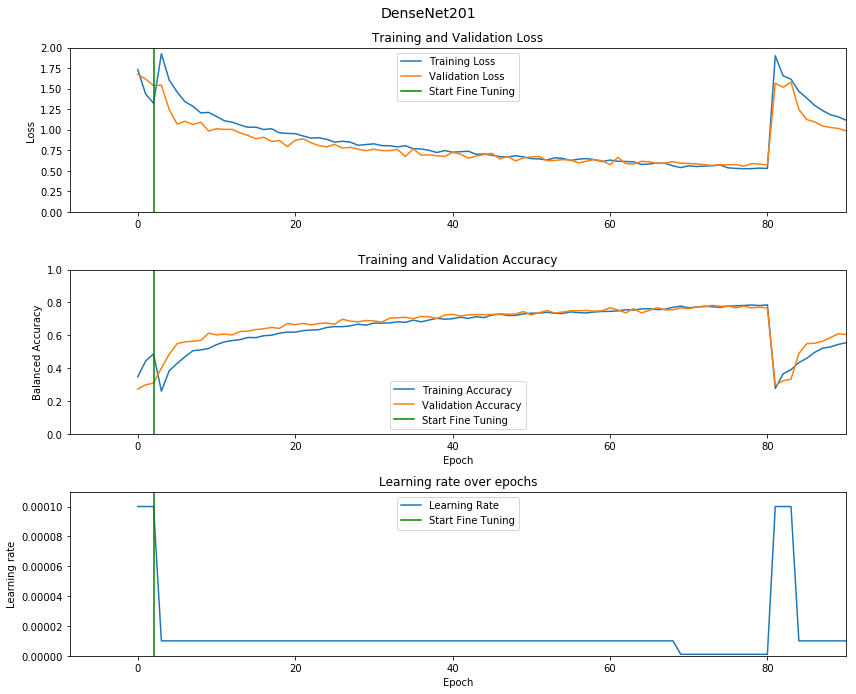

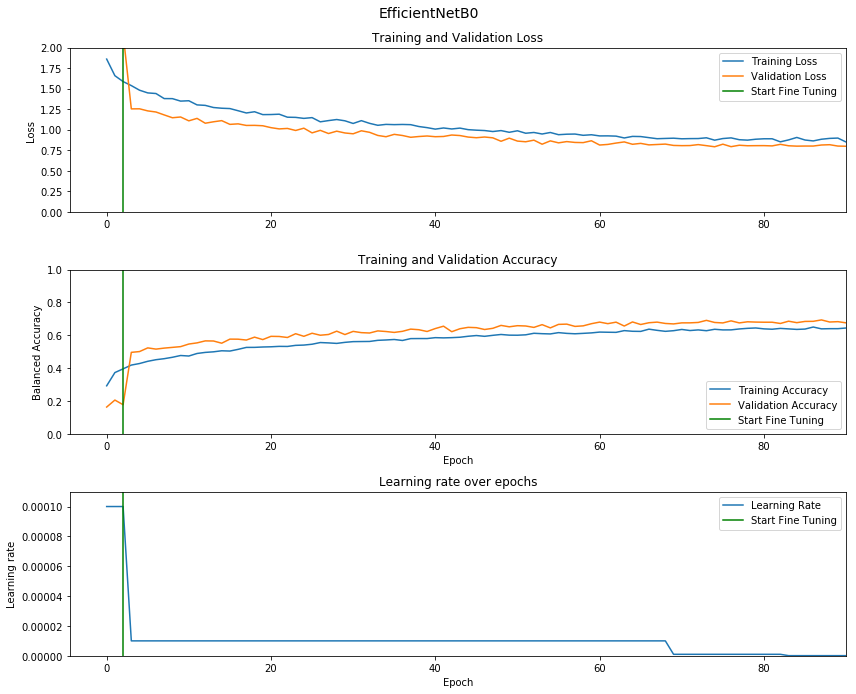

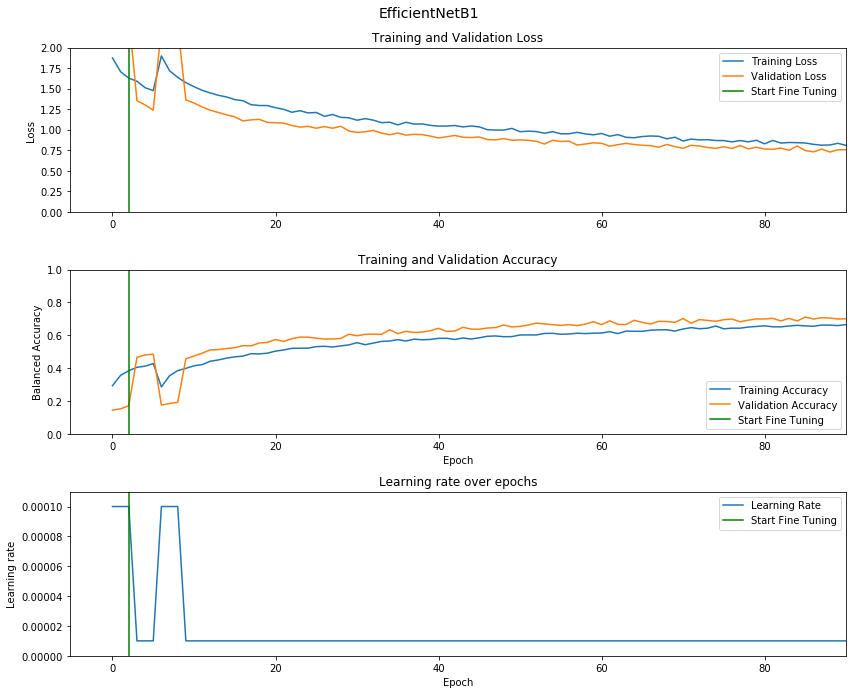

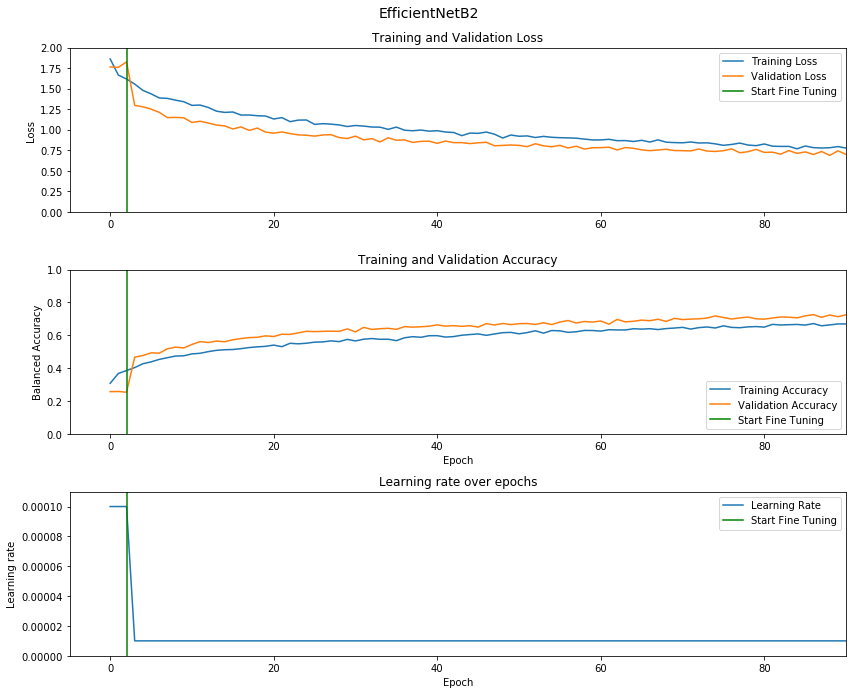

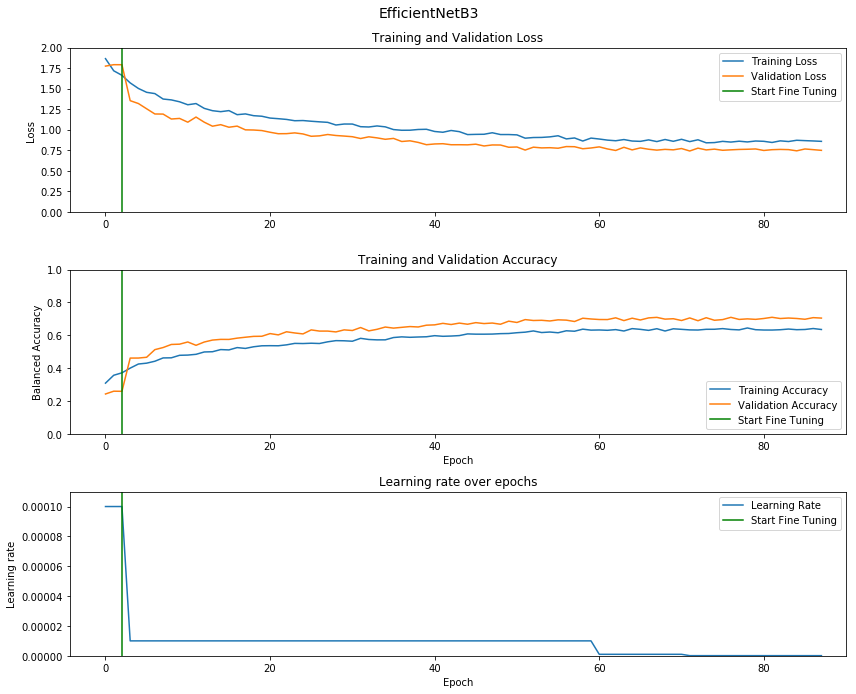

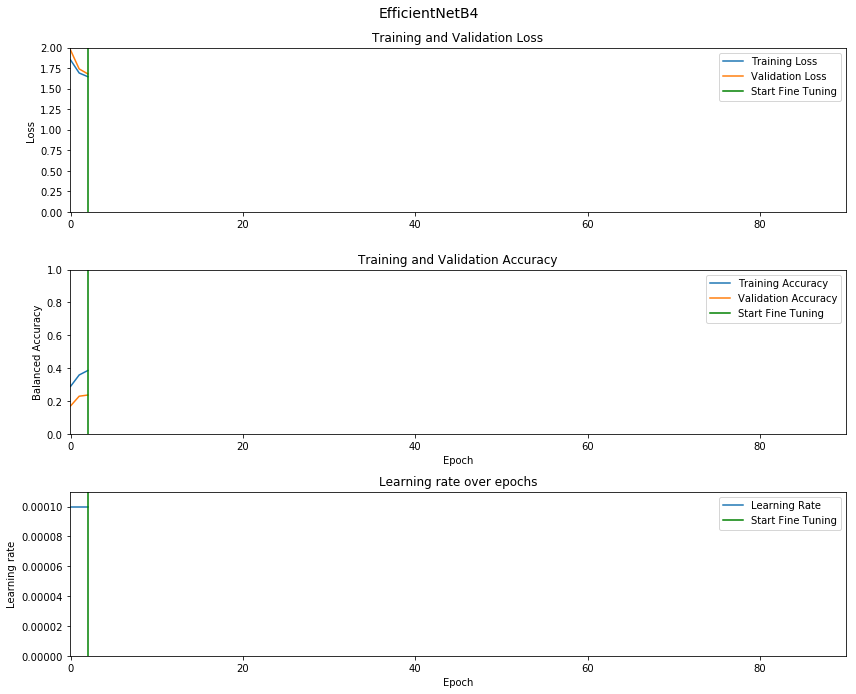

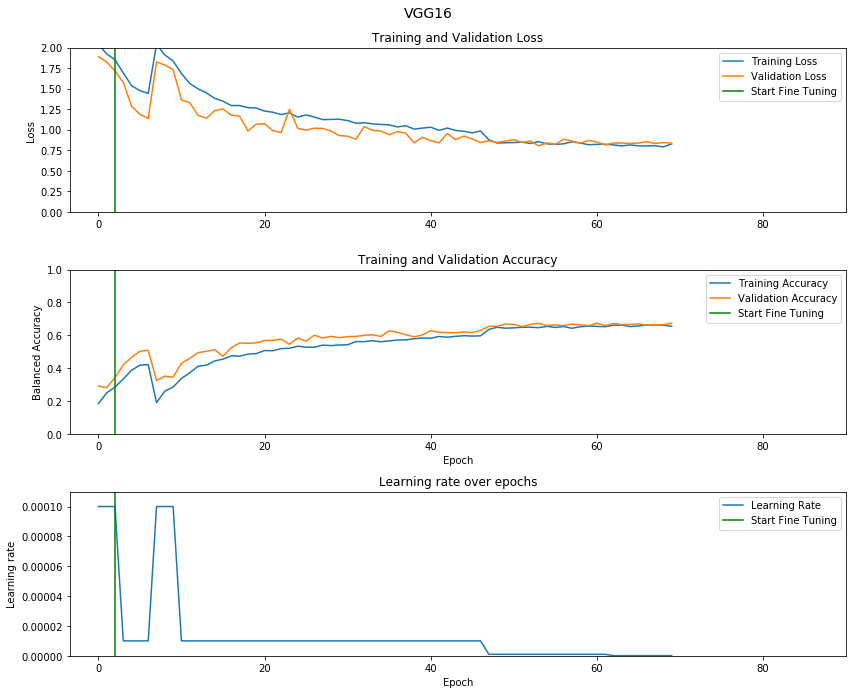

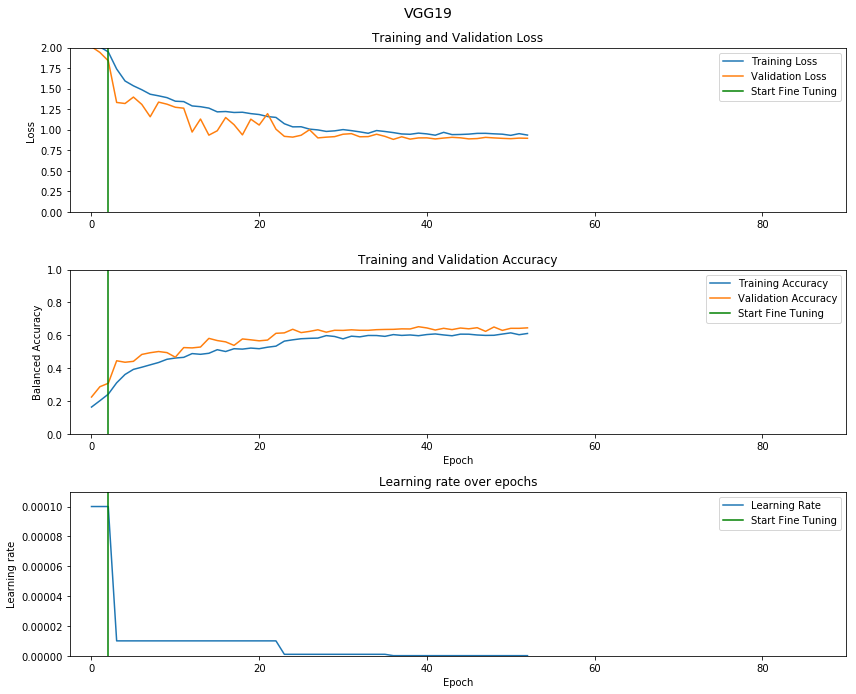

In [13]:
model_names = ['DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'VGG16', 'VGG19', 'ResNet50']
feature_extract_epochs = 3

for model_name in model_names:
    file_path = os.path.join("..", history_folder, model_name, "{}.training.csv".format(model_name))
    print(file_path)
    if os.path.exists(file_path):
        fig = plot_complexity_graph(csv_file=file_path,
                              title="{}".format(model_name),
                              figsize=(12, 10),
                              feature_extract_epochs=feature_extract_epochs)
        fig.savefig(os.path.join("..", history_folder, model_name, "{}.training.svg".format(model_name)), format='svg',
                    bbox_inches='tight', pad_inches=0)

### Classify Dermoscopic Images using Transfer Learning Models

In [ ]:
import random
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from utils import path_to_tensor
from base_model_param import get_transfer_model_param_map
from lesion_classifier import LesionClassifier
from metrics import balanced_accuracy
from pathlib import Path

def transfer_classify(model, img_path, data_format, augmentation_pipeline, preprocessing_function, topk=8):
    img = Image.open(img_path) # PIL Image
    img = augmentation_pipeline.perform_operations(img)
    img = img_to_array(img, data_format=data_format, dtype='float32')
    img = preprocessing_function(img, data_format=data_format)
    img = np.expand_dims(img, axis=0)
    predicted_vector = model.predict(img)
    idx_topk = np.argsort(-predicted_vector)[0, :topk]
    probs = np.take(predicted_vector, idx_topk)
    names = [known_category_names[idx] for idx in idx_topk]
    return idx_topk, names, probs

topk = known_category_num
model_param_map = get_transfer_model_param_map()
model_name = 'DenseNet201'
model = load_model(filepath=os.path.join("..", model_folder, "{}_best_balanced_acc.hdf5".format(model_name)),
                   custom_objects={'balanced_accuracy': balanced_accuracy(known_category_num)})
augmentation_pipeline = LesionClassifier.create_aug_pipeline_val(model_param_map[model_name].input_size)
preprocessing_function = model_param_map[model_name].preprocessing_func
image_data_format = K.image_data_format()

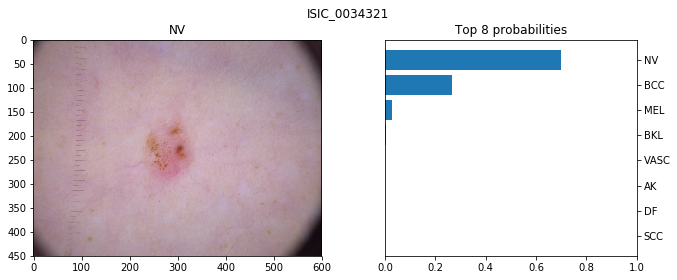

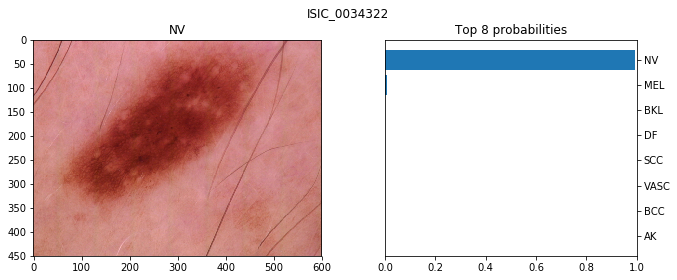

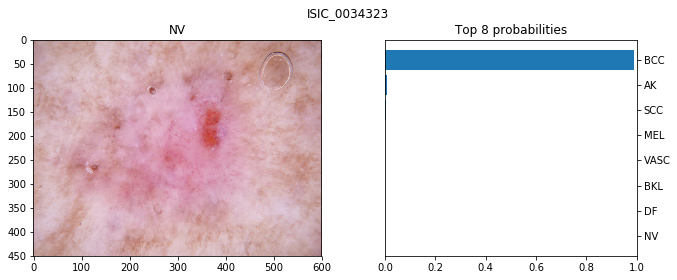

In [10]:
imgs_crop_marker = ['../data/isic2019/ISIC_2019_Test_Input/ISIC_0034321.jpg',
                    '../data/isic2019/ISIC_2019_Test_Input/ISIC_0034322.jpg',
                    '../data/isic2019/ISIC_2019_Test_Input/ISIC_0034323.jpg']

for img_path in imgs_crop_marker:
    idx_topk, names, probs = transfer_classify(model, img_path, image_data_format, augmentation_pipeline, preprocessing_function, topk)
    fig = plot_prob_bars(img_title='NV',
                         img_path=img_path,
                         labels=names,
                         probs=probs,
                         topk=topk,
                         title=Path(img_path).stem)
    fig.savefig("{}_Probs.jpg".format(Path(img_path).stem), format='jpg', dpi=150, bbox_inches='tight', pad_inches=0)

## Predict Validation Set

### Predict Validation Set by Different Models

In [4]:
!python ../main.py ../data/isic2019 --predval --model EfficientNetB0 EfficientNetB1 EfficientNetB2 EfficientNetB3 EfficientNetB4 VGG16 VGG19 ResNet50 --modelfolder ../models

2020-02-11 16:28:30.472697: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-02-11 16:28:30.510939: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3499515000 Hz
2020-02-11 16:28:30.513525: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555c9532c960 executing computations on platform Host. Devices:
2020-02-11 16:28:30.513578: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2020-02-11 16:28:30.514578: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-02-11 16:28:32.915789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:0a:00.0
2020-02-11 16:28:32.916348: I tensorflow/core/common_ru

Save "val_predict_results/Validation_Set_GroundTruth.csv"
===== Predict validation set using "EfficientNetB0_best_balanced_acc" model =====
2020-02-11 16:28:33.785946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:0a:00.0
2020-02-11 16:28:33.786503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:0b:00.0
2020-02-11 16:28:33.786555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-02-11 16:28:33.787021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:41:00.0


2020-02-11 16:29:07.719312: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-02-11 16:29:07.954976: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
159/159 [==============================] - 20s 129ms/step
===== Predict validation set using "EfficientNetB1_best_balanced_acc" model =====
159/159 [==============================] - 19s 122ms/step
===== Predict validation set using "EfficientNetB2_best_balanced_acc" model =====
159/159 [==============================] - 21s 131ms/step
===== Predict validation set using "EfficientNetB3_best_balanced_acc" model =====
159/159 [==============================] - 21s 133ms/step
===== Predict validation set using "EfficientNetB4_best_balanced_acc" model =====
159/159 [==============================] - 36s 229ms/step
===== Predict validation set using "VGG16_best_balanced_acc" model =====
159/159 [============

### Ensemble Models' Predictions on Validation Set

In [25]:
from utils import ensemble_predictions

ensemble_predictions(pred_result_folder_val, known_category_names, model_names=['DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3','ResNet50'])

Save "val_predict_results/Ensemble_best_balanced_acc.csv"
Save "val_predict_results/Ensemble_best_loss.csv"
Save "val_predict_results/Ensemble_latest.csv"


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,category,pred_category
0,ISIC_0070596,0.971670,0.015020,0.000430,3.201061e-05,0.012775,0.000028,0.000006,0.000039,0,0
1,ISIC_0061244,0.621627,0.226720,0.002856,2.040082e-03,0.095453,0.000182,0.000017,0.051105,0,0
2,ISIC_0029813,0.001262,0.983259,0.000259,2.659553e-04,0.003006,0.011716,0.000190,0.000042,1,1
3,ISIC_0032739,0.093299,0.888207,0.000028,1.824843e-04,0.011987,0.000729,0.000021,0.005546,1,1
4,ISIC_0064041,0.315752,0.541593,0.002404,4.747990e-03,0.129496,0.001040,0.002870,0.002096,4,1
...,...,...,...,...,...,...,...,...,...,...,...
5062,ISIC_0014612_downsampled,0.038764,0.011641,0.008116,5.926348e-02,0.799843,0.005831,0.000118,0.076425,4,4
5063,ISIC_0000324,0.142297,0.654353,0.000266,2.515551e-03,0.200197,0.000333,0.000009,0.000029,1,1
5064,ISIC_0071830,0.014117,0.000398,0.096192,8.567351e-01,0.002917,0.000037,0.000501,0.029103,3,3
5065,ISIC_0028349,0.003821,0.996065,0.000002,8.873594e-08,0.000013,0.000047,0.000049,0.000002,1,1


### Load Prediction Results on Validation Set

Model selection criteria:  best_balanced_acc
========== DenseNet201 ==========
balanced_accuracy_score:  0.7643129043475154
macro recall_score:  0.7643129043475154
categorical_crossentropy:  0.5905676652088112
weighted categorical_crossentropy:  0.7515367585329117

========== EfficientNetB0 ==========
balanced_accuracy_score:  0.7216849634297142
macro recall_score:  0.7216849634297142
categorical_crossentropy:  0.8105678004980379
weighted categorical_crossentropy:  0.8147270949833394

========== EfficientNetB1 ==========
balanced_accuracy_score:  0.7381814979518107
macro recall_score:  0.7381814979518107
categorical_crossentropy:  0.7148268182895525
weighted categorical_crossentropy:  0.788545991730528

========== EfficientNetB2 ==========
balanced_accuracy_score:  0.7536389622108607
macro recall_score:  0.7536389622108607
categorical_crossentropy:  0.6965789042089698
weighted categorical_crossentropy:  0.7775184679644959

========== EfficientNetB3 ==========
balanced_accuracy_score:  

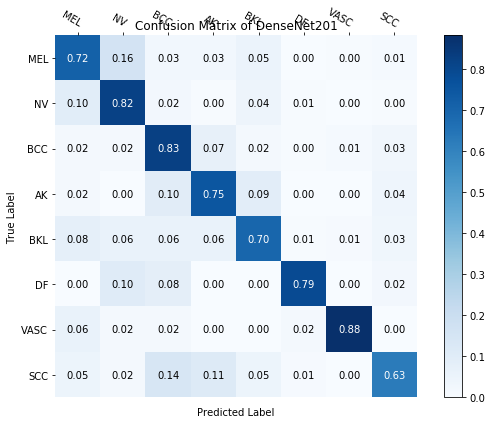

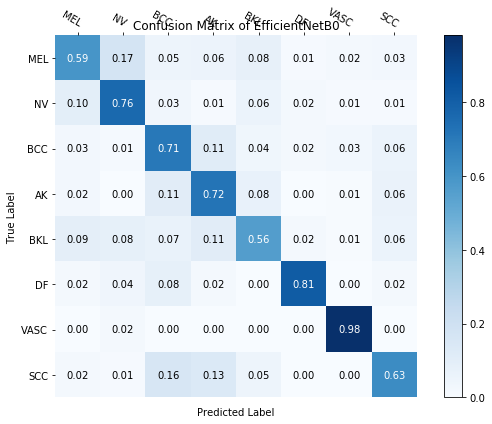

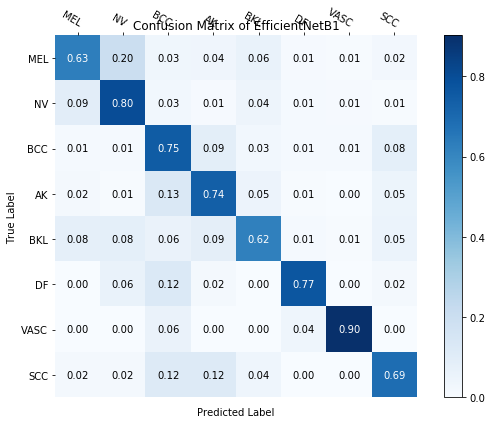

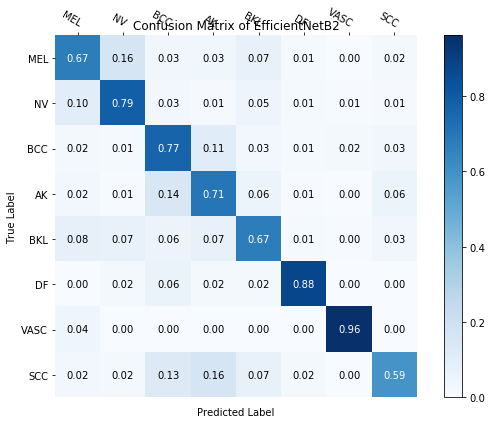

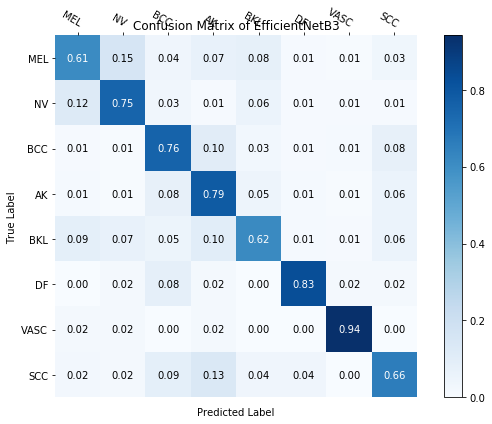

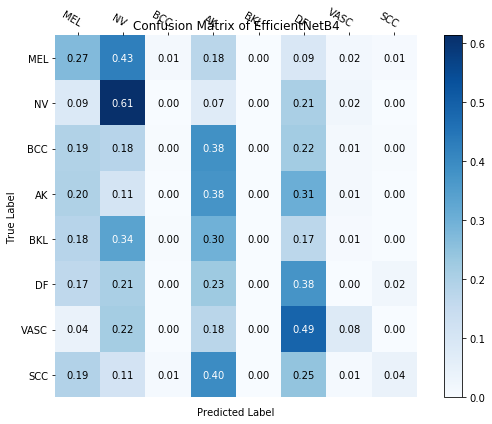

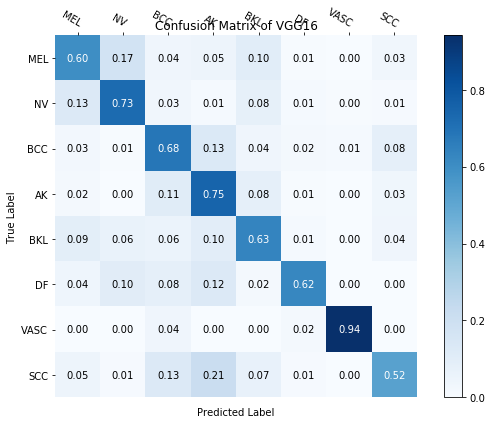

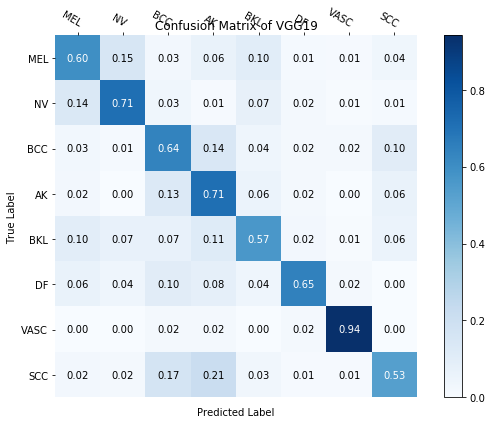

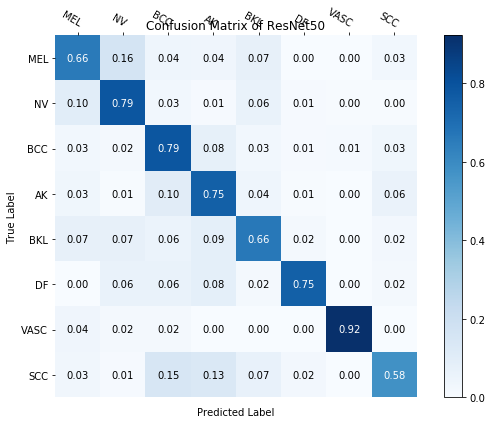

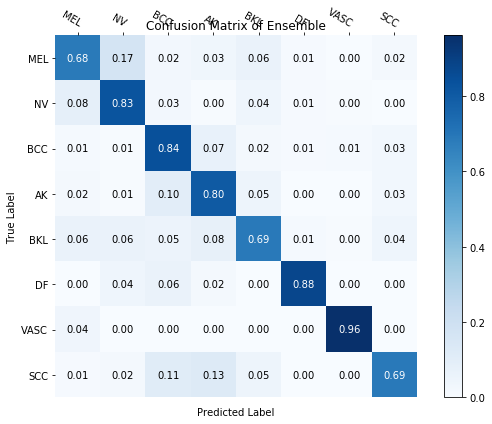

In [27]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, recall_score
from visuals import plot_confusion_matrix
from tensorflow.keras import utils
from keras_numpy_backend import categorical_crossentropy
model_names = ['DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'VGG16', 'VGG19', 'ResNet50', 'Ensemble']
#model_names = ['DenseNet201']
postfix = 'best_balanced_acc'
print('Model selection criteria: ', postfix)

for model_name in model_names:
    # Load predicted results
    file_path = os.path.join(pred_result_folder_val, "{}_{}.csv".format(model_name, postfix))
    if not os.path.exists(file_path):
        continue

    print("========== {} ==========".format(model_name))
    df = pd.read_csv(file_path)
    y_true = df['category']
    y_pred = df['pred_category']

    # Compute Balanced Accuracy
    print('balanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))
    print('macro recall_score: ', recall_score(y_true, y_pred, average='macro'))

    # Compute categorical_crossentropy
    y_true_onehot = utils.to_categorical(df['category'], num_classes=known_category_num)
    y_pred_onehot = np.array(df.iloc[:,1:9])
    print('categorical_crossentropy: ',
          np.average(categorical_crossentropy(y_true_onehot, y_pred_onehot)))

    # Compute weighted categorical_crossentropy
    print('weighted categorical_crossentropy: ',
          np.average(categorical_crossentropy(y_true_onehot, y_pred_onehot, class_weights=class_weights)))

    # Confusion Matrix
    fig = plot_confusion_matrix(y_true, y_pred, known_category_names, normalize=True,
                                title="Confusion Matrix of {}".format(model_name),
                                figsize=(8, 6))
    fig.savefig(os.path.join(pred_result_folder_val, "{}_{}.svg".format(model_name, postfix)), format='svg',
                bbox_inches='tight', pad_inches=0)
    print('')

Validation set has 5067 samples.

========== Ground Truth ==========
'MEL':	904	(17.84%)
'NV':	2575	(50.82%)
'BCC':	665	(13.12%)
'AK':	173	(3.41%)
'BKL':	525	(10.36%)
'DF':	48	(0.95%)
'VASC':	51	(1.01%)
'SCC':	126	(2.49%)

========== DenseNet201 Prediction ==========
'MEL':	960	(18.95%)
'NV':	2313	(45.65%)
'BCC':	707	(13.95%)
'AK':	257	(5.07%)
'BKL':	558	(11.01%)
'DF':	62	(1.22%)
'VASC':	67	(1.32%)
'SCC':	143	(2.82%)

========== EfficientNetB0 Prediction ==========
'MEL':	863	(17.03%)
'NV':	2176	(42.94%)
'BCC':	674	(13.30%)
'AK':	351	(6.93%)
'BKL':	561	(11.07%)
'DF':	118	(2.33%)
'VASC':	112	(2.21%)
'SCC':	212	(4.18%)

========== EfficientNetB1 Prediction ==========
'MEL':	864	(17.05%)
'NV':	2304	(45.47%)
'BCC':	677	(13.36%)
'AK':	305	(6.02%)
'BKL':	528	(10.42%)
'DF':	92	(1.82%)
'VASC':	85	(1.68%)
'SCC':	212	(4.18%)

========== EfficientNetB2 Prediction ==========
'MEL':	942	(18.59%)
'NV':	2216	(43.73%)
'BCC':	688	(13.58%)
'AK':	305	(6.02%)
'BKL':	574	(11.33%)
'DF':	102	(2.01%)
'VASC':	

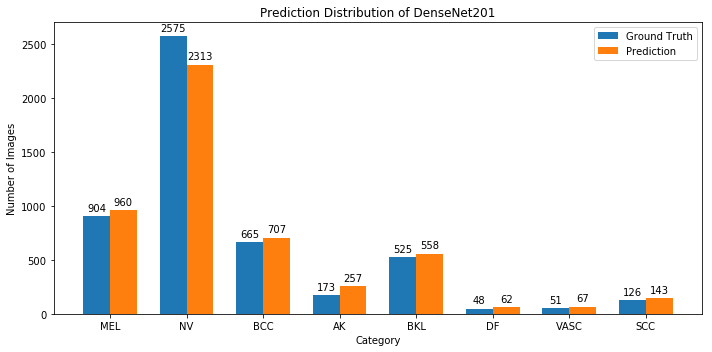

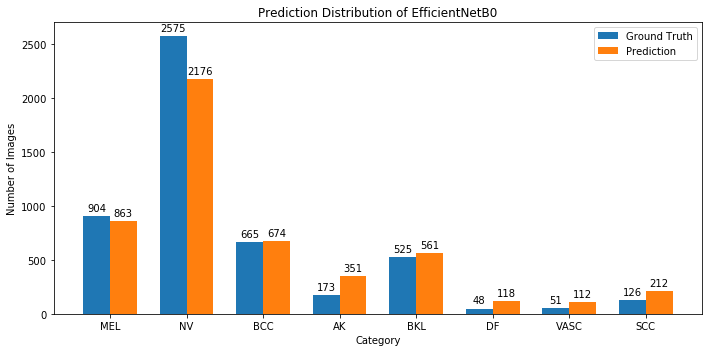

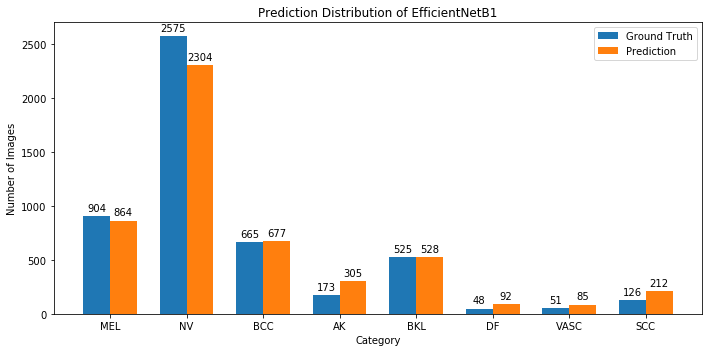

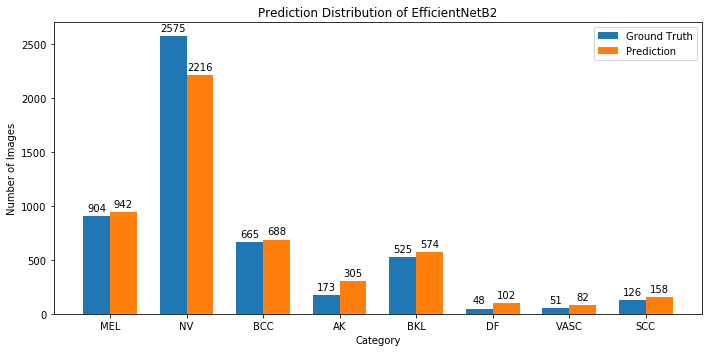

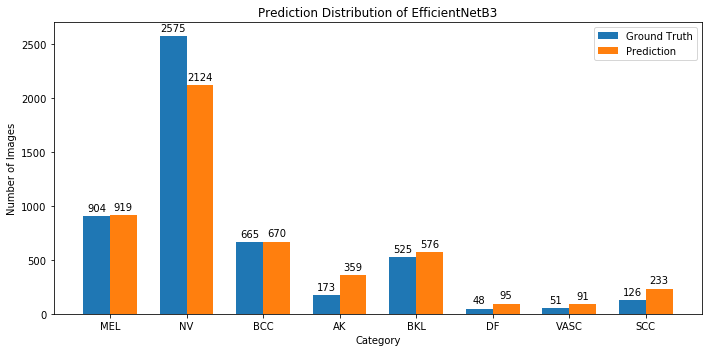

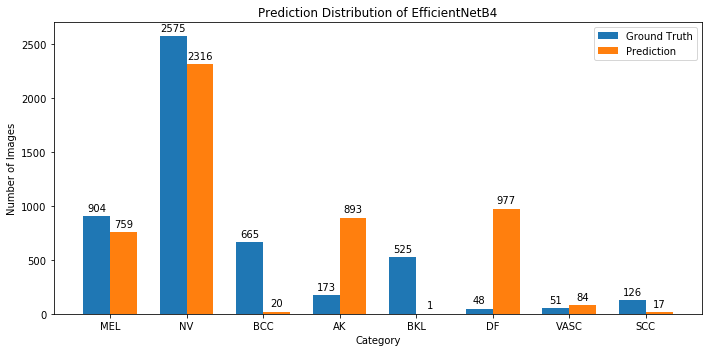

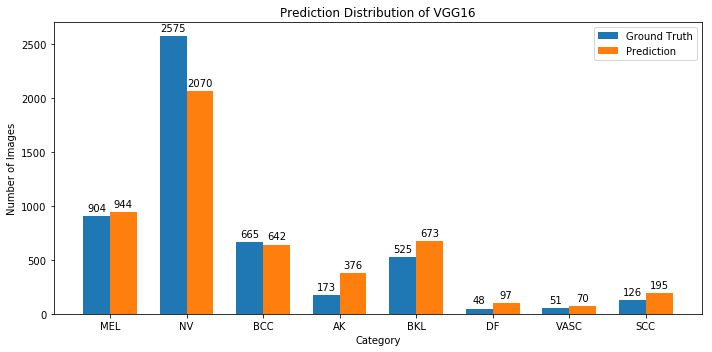

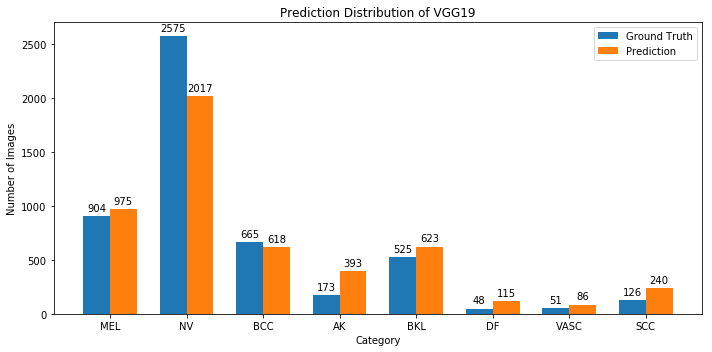

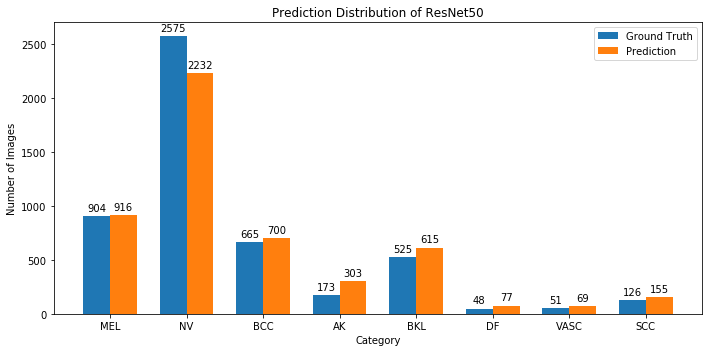

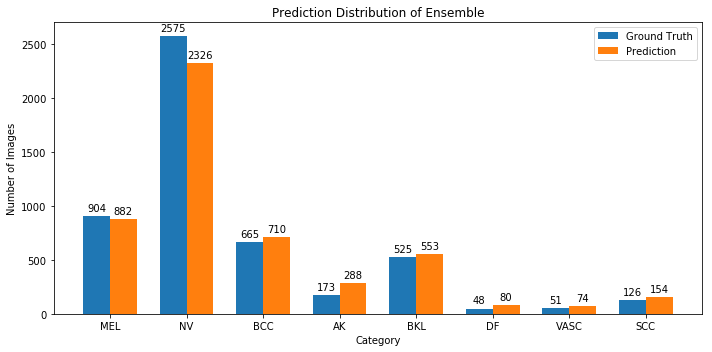

In [28]:
from visuals import plot_grouped_2bars

sample_count_val = y_true.shape[0]
print("Validation set has {} samples.\n".format(sample_count_val))

print('========== Ground Truth ==========')
count_true = Counter(y_true)
for i, c in enumerate(known_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_true[i], count_true[i]*100/sample_count_val))

for model_name in model_names:
    # Load predicted results
    file_path = os.path.join(pred_result_folder_val, "{}_{}.csv".format(model_name, postfix))
    if not os.path.exists(file_path):
        continue

    print("\n========== {} Prediction ==========".format(model_name))
    df = pd.read_csv(file_path)
    y_pred = df['pred_category']
    
    count_pred = Counter(y_pred)
    for i, c in enumerate(known_category_names):
        print("'%s':\t%d\t(%.2f%%)" % (c, count_pred[i], count_pred[i]*100/sample_count_val))

    # Plot Prediction Distribution
    plot_grouped_2bars(
        scalars=[[count_true[i] for i in range(known_category_num)],
                 [count_pred[i] for i in range(known_category_num)]],
        scalarlabels=['Ground Truth', 'Prediction'],
        xticklabels=known_category_names,
        xlabel='Category',
        ylabel='Number of Images',
        title="Prediction Distribution of {}".format(model_name)
    )